In [1]:
experiment = 'exp1'
ks = {16}

# General

## 1. Count the real k-mers in the reads file

The next step is to go through all the reads in the reads file and count the number of times each k-mer appears.

In [2]:
kmer_counts_reads = {}
with open(experiment + '/reads.txt', 'r') as reads_file:
    for k in ks:
        kmer_counts_reads[k] = {}
        for line in reads_file:
            for i in range(len(line) - k):
                kmer = line[i:i+k]
                if kmer not in kmer_counts_reads[k]:
                    kmer_counts_reads[k][kmer] = 0
                kmer_counts_reads[k][kmer] += 1

In [8]:
for kmer in kmer_counts_reads[16]:
    if kmer_counts_reads[16][kmer] < 1000 and kmer_counts_reads[16][kmer] >= 40:
        continue
    print(kmer, kmer_counts_reads[16][kmer])

TGCCTGATGCGACGCT 4202
GCCTGATGCGACGCTG 2592
CCTGATGCGACGCTGG 1220
CTGATGCGACGCTGGC 1302
TGATGCGACGCTGGCG 1300
GATGCGACGCTGGCGC 1745
ATGCGACGCTGGCGCG 1745
TGCGACGCTGGCGCGT 1746
GCGACGCTGGCGCGTC 1744
CGACGCTGGCGCGTCT 1752
GACGCTGGCGCGTCTT 1677
ACGCTGGCGCGTCTTA 1678
CGCTGGCGCGTCTTAT 1678
GCTGGCGCGTCTTATC 1678
CTGGCGCGTCTTATCA 1304
CGCGTCTTATCAGGCC 3497
GCGTCTTATCAGGCCT 3548
CGTCTTATCAGGCCTA 3461
GTCTTATCAGGCCTAC 3463
TCTTATCAGGCCTACA 2427
GTAGGTCGGATAAGGC 1218
TAGGTCGGATAAGGCG 1128
GATAAGGCGTTTACGC 2641
ATAAGGCGTTTACGCC 2652
TAAGGCGTTTACGCCG 2654
AAGGCGTTTACGCCGC 2659
AGGCGTTTACGCCGCA 2653
GGCGTTTACGCCGCAT 2724
GCGTTTACGCCGCATC 2793
GCCTGATGCGACGCTT 2185
CCTGATGCGACGCTTG 1491
CGGATAAGGCGTTCAC 2754
GGATAAGGCGTTCACG 3064
GATAAGGCGTTCACGC 3353
ATAAGGCGTTCACGCC 3359
TAAGGCGTTCACGCCG 3357
GATGCCTGATGCGACG 1341
ATGCCTGATGCGACGC 2936
CTTATCAGGCCTACAA 1835
CCGTAGGCCGGATAAG 1396
CGTAGGCCGGATAAGG 1648
GTAGGCCGGATAAGGC 4591
TAGGCCGGATAAGGCG 4435
CGCCGCATCCGGCAAT 1095
CAATGCCTGATGCGAC 1109
AATGCCTGAT

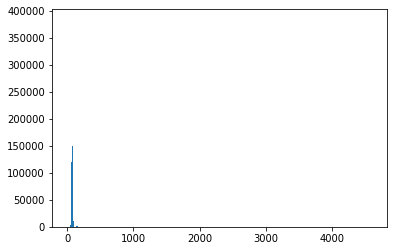

In [5]:
import matplotlib.pyplot as plt

plt.hist(kmer_counts_reads[16].values(), bins=4000)
plt.show()

# Single Experiment Analysis

## 1. Load Navigation Results

The navigation results can be found in the files named `K<>W<>D<>T<>` inside the experiments folder. They're formatted as

```
<k-mer>: <count> <out edges (in binary)>
```

For example:

```
AGACATGCATA: 15 0101
```

The first step here is to read the navigation result file from the given experiment and parse it into a dictionary of the form

```
{
    <k-mer>: {
        'count': <count>,
        'out_edges': <out edges>
    }
}
```

In [25]:
navigated_kmers = {}
with open(f'{experiment}/K16W3680000D8T1') as navigation_file:
    for line in navigation_file:
        kmer, query_result = line.strip().split(':')
        count, out_edges = query_result.strip().split(' ')
        count = int(count)
        out_edges = int(out_edges, 2)
        navigated_kmers[kmer] = {
            'count': count,
            'out_edges': out_edges
        }

## 2. Results Summary

The results from the experiment are compared to the real k-mers.

The real number of distinct k-mers is printed, followed by the number of distinct k-mers that were visited during the graph traversal, and the number of k-mers that were found to be present in the graph.

Then the number of false negatives is printed. A false negative is a k-mer that is found in the reads but was not found to be present in the graph. A false negative rate is also printed, defined as proportion of real k-mers that were not found in the graph (i.e.: # false negatives / # real k-mers).

Finally, the number of false positives is printed. A false positive is a k-mer that is considered to be in the graph that, however, is not found in the reads. A false positive rate is printed, defined as the proportion of k-mers that were found in the graph but not in the reads (i.e.: # false positives / # k-mers in the graph).

In [36]:
print(f'Total k-mers in reads: {len(kmer_counts_reads[16])}')

print(f'Total Visited k-mers: {len(navigated_kmers)}')

found_kmers = set(kmer for kmer in navigated_kmers if navigated_kmers[kmer]['count'] >= 1)
print(f'Found k-mers: {len(found_kmers)}')

false_negatives = set(kmer for kmer in kmer_counts_reads[16] if kmer not in found_kmers)
print(f'False Negatives (Count): {len(false_negatives)}')
print(f'False Negatives (Rate): {100*len(false_negatives) / len(kmer_counts_reads[16])}%')

false_positives = set(kmer for kmer in found_kmers if kmer not in kmer_counts_reads[16])
print(f'False Positives (Count): {len(false_positives)}')
print(f'False Positives (Rate): {100*len(false_positives) / len(found_kmers)}%')


Total k-mers in reads: 4544542
Total Visited k-mers: 4630589
Found k-mers: 4550152
False Negatives (Count): 0
False Negatives (Rate): 0.0%
False Positives (Count): 5610
False Positives (Rate): 0.12329258451146248%


# Bulk Analysis

## 1. Load Navigation Results for All Experiments

All the experiment files are read and parsed, with the results being stored in a list of dictionaries of the form

```
[
    {
        'k': k,
        'W': W,
        'D': D,
        'presence_threshold': presence_threshold,
        'navigation_results': {
            <k-mer>: (<count>, <out edges>)
        }
    },
    ...
]
```

In [2]:
import os
import re

result_file_name_format = re.compile(r'K(\d+)W(\d+)D(\d+)T(\d+)')
result_files = list(filter(lambda file_name: result_file_name_format.match(file_name), os.listdir(experiment)))

def process_results_file(file_name):
    navigation_results = {}
    with open(f'{experiment}/{file_name}', 'r') as results_file:
        for line in results_file:
            kmer, query_result = line.strip().split(": ")
            count, out_edges = query_result.strip().split(" ")
            navigation_results[kmer] = (int(count), int(out_edges, 2))
    
    return navigation_results

ks = set()
results = []
for file in result_files:
    filename_re_match = result_file_name_format.match(file)
    k = int(filename_re_match.group(1))
    ks.add(k)
    W = int(filename_re_match.group(2))
    D = int(filename_re_match.group(3))
    presence_threshold = int(result_file_name_format.match(file).group(4))
    print(file)
    navigation_results = process_results_file(file)
    results.append({
        "k": k,
        "W": W,
        "D": D,
        "presence_threshold": presence_threshold,
        "navigation_results": navigation_results
    })

K16W2300000D8T1
K16W2300000D8T40
K16W3220000D8T1
K16W3220000D8T40
K16W2760000D8T1
K16W3680000D8T1
K16W3680000D8T40
K16W2760000D8T40


## 2. Expand Results

From the navigation results, the number of visited k-mers, as well as the number of k-mers that were found to be present in the graph are calculated. The false positive k-mers and false negatives are identified and stored, as well as their counts and rates. This happens directly on the dictionary, and the results are, then, transformed into a Pandas DataFrame.

In [4]:
for result in results:
    visited_kmers = set(result['navigation_results'])
    actual_kmers = set(kmer_counts_reads[result['k']])
    found_kmers = set(filter(lambda kmer: result['navigation_results'][kmer][0] >= result['presence_threshold'], visited_kmers))
    false_positives = found_kmers - actual_kmers
    false_negatives = actual_kmers - found_kmers
    result['visited_count'] = len(visited_kmers)
    result['found_count'] = len(found_kmers)
    result['false_positives'] = false_positives
    result['false_negatives'] = false_negatives
    result['false_positive_count'] = len(false_positives)
    result['false_negative_count'] = len(false_negatives)
    result['false_positive_rate'] = len(false_positives) / len(found_kmers)
    result['false_negative_rate'] = len(false_negatives) / len(actual_kmers)

In [5]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.head()

,k,W,D,presence_threshold,navigation_results,visited_count,found_count,false_positives,false_negatives,false_positive_count,false_negative_count,false_positive_rate,false_negative_rate
0,16,2300000,8,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",5435444,4818561,"{ATGCCCCATACCGTTG, CAACCGCCGAGCACAG, ATACACACT...",{},274019,0,0.056867,0.000000
1,16,2300000,8,40,"{'ATGCCTGATGCGACGC': (2936, 3), 'ATAAGGCGTTCAC...",5434945,4818178,"{ATGCCCCATACCGTTG, CAACCGCCGAGCACAG, ATACACACT...","{CGAGACACGGCAATGT, ATAGCAGCTTCTGAAC, TGGTTACAA...",273897,261,0.056847,0.000057
2,16,3220000,8,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",4714849,4563113,"{CGGATTCTTTGGTCGT, AGTACCGCGATGGCAT, TGAGAGGTG...",{},18571,0,0.004070,0.000000
3,16,3220000,8,40,"{'ATGCCTGATGCGACGC': (2936, 3), 'ATAAGGCGTTCAC...",4714498,4562810,"{CGGATTCTTTGGTCGT, AGTACCGCGATGGCAT, TGAGAGGTG...","{CGAGACACGGCAATGT, ATAGCAGCTTCTGAAC, TGGTTACAA...",18557,289,0.004067,0.000064
4,16,2760000,8,1,"{'GTTATGATACGTTTCG': (159, 4), 'CGCAACGTCAATAC...",4910258,4612067,"{ATCATACTCTGTTTAG, ACGCCGCTTTCTGGTT, CGGGAATGC...",{},67525,0,0.014641,0.000000


## 3. Resulting Figures

From these results, some figures are generated. Namely, the number of distinct k-mers that were visited and found for each experiment. The number of false positives and negatives, and the corresponding rates.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
mpl.style.use('seaborn')

In [7]:
filtered_df = results_df #.loc[results_df['presence_threshold'] == 1]
filtered_df = filtered_df.sort_values(['D', 'W', 'presence_threshold'])

In [8]:
groupby_column = 'presence_threshold'
colors = cm.jet(np.linspace(0, 1, filtered_df[groupby_column].max()+1))

### 3.1. Number of Distinct k-mers visited (and found)

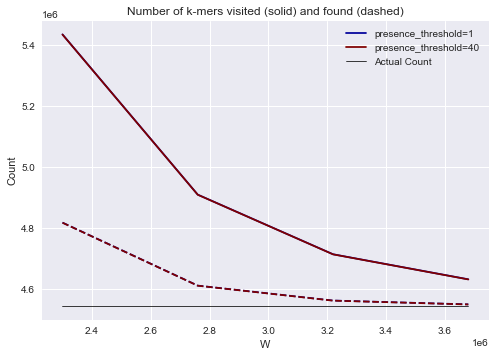

In [9]:
for D, group in filtered_df.groupby(groupby_column):
    plt.plot(group['W'], group['visited_count'], label=f'{groupby_column}={D}', color=colors[D])
    plt.plot(group['W'], group['found_count'], '--', color=colors[D])

plt.plot([filtered_df['W'].min(), filtered_df['W'].max()], [len(kmer_counts_reads[filtered_df['k'].min()]), len(kmer_counts_reads[filtered_df['k'].min()])], color='black', label='Actual Count', linewidth=0.75)
plt.legend()
plt.xlabel('W')
plt.ylabel('Count')
plt.title('Number of k-mers visited (solid) and found (dashed)')
plt.show()

### 3.2. Number of false positives and false negatives

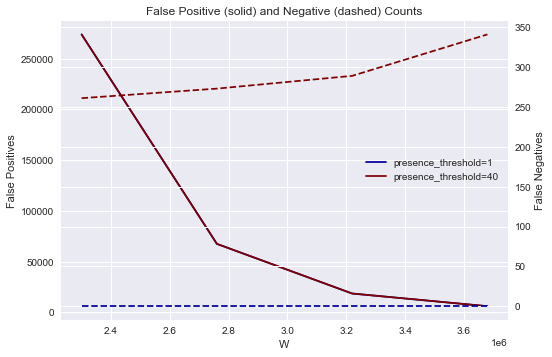

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for D, group in filtered_df.groupby(groupby_column):
    ax1.plot(group['W'], group['false_positive_count'], label=f'{groupby_column}={D}', color=colors[D])
    ax2.plot(group['W'], group['false_negative_count'], '--', color=colors[D])
ax1.legend(loc='right')
ax1.set_xlabel('W')
ax1.set_ylabel('False Positives')
ax2.set_ylabel('False Negatives')
plt.title('False Positive (solid) and Negative (dashed) Counts')
plt.show()

#### 3.2.1. False positive and false negative rates

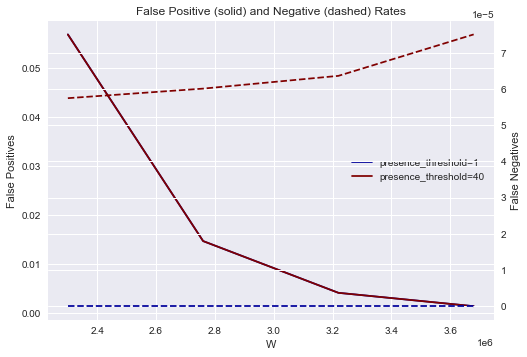

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for D, group in filtered_df.groupby(groupby_column):
    ax1.plot(group['W'], group['false_positive_rate'], label=f'{groupby_column}={D}', color=colors[D])
    ax2.plot(group['W'], group['false_negative_rate'], '--', color=colors[D])
ax1.legend(loc='right')
ax1.set_xlabel('W')
ax1.set_ylabel('False Positives')
ax2.set_ylabel('False Negatives')
plt.title('False Positive (solid) and Negative (dashed) Rates')
plt.show()

In [12]:
filtered_df[['presence_threshold', 'W', 'visited_count', 'found_count', 'false_positive_count', 'false_negative_count']]

,presence_threshold,W,visited_count,found_count,false_positive_count,false_negative_count
0,1,2300000,5435444,4818561,274019,0
1,40,2300000,5434945,4818178,273897,261
4,1,2760000,4910258,4612067,67525,0
7,40,2760000,4909894,4611770,67501,273
2,1,3220000,4714849,4563113,18571,0
3,40,3220000,4714498,4562810,18557,289
5,1,3680000,4632702,4550604,6062,0
6,40,3680000,4632337,4550262,6061,341
